# Predict Number of Day's Supply for Atorvastatin prescribed by an HCP in 2019

References:
- https://www.udemy.com/course/statistics-for-data-science-and-business-analysis/learn/lecture/8742394#reviews
- https://www.cms.gov/newsroom/data
- https://data.cms.gov/provider-summary-by-type-of-service/medicare-part-d-prescribers/medicare-part-d-prescribers-by-provider-and-drug/data
- https://data.cms.gov/resources/medicare-part-d-prescribers-by-provider-and-drug-data-dictionary
-https://clincalc.com/DrugStats/Top300Drugs.aspx
-https://bfdykstra.github.io/2016/11/17/Endogeneity-and-Instrumental-Variable-Regression.html
-https://towardsdatascience.com/endogeneity-the-reason-why-we-should-know-about-data-part-i-80ec33df66ae

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from sklearn.preprocessing import OneHotEncoder

In [2]:
df=pd.read_csv("input/Medicare_Part_D_Prescribers_by_Provider_and_Drug_2019.csv")
df['Gnrc_Name']=df['Gnrc_Name'].str.strip()
df['Gnrc_Name']=df['Gnrc_Name'].str.lower()
df=df[df['Gnrc_Name'].str.contains('atorvastatin')]
df.shape

(325631, 9)

# Pre-processing

In [3]:
print("Number of missing records per column:\n",df.isna().sum())

Number of missing records per column:
 Prscrbr_NPI                  0
Prscrbr_State_Abrvtn         0
Prscrbr_Type                 0
Gnrc_Name                    0
Tot_Clms                     0
Tot_Day_Suply                0
Tot_Drug_Cst                 0
Tot_Benes                69184
GE65_Tot_Benes          249948
dtype: int64


To simplify the analysis, remove all rows with missing information

In [4]:
df.dropna(inplace=True)

Check if each record corresponds to a unique HCP: There are duplicate NPI's, so there are duplicate HCP's - remove HCP's with duplicate records b/c unsure if merging information results in overcounting

In [5]:
dup_bool_ser=df.duplicated(subset=['Prscrbr_NPI','Prscrbr_State_Abrvtn','Prscrbr_Type'])
dup_bool_ser.unique()
df.drop_duplicates(subset=['Prscrbr_NPI'],inplace=True,keep=False)

Remove HCP's who do not have beneficiaries older than 65

In [6]:
df=df[df['GE65_Tot_Benes']>0]

Remove HCP's with unknown States ('XX') or foreign Country ('ZZ')

In [7]:
df=df[~df['Prscrbr_State_Abrvtn'].isin(['XX','ZZ'])]

HCP Spec Selection

In [8]:
df.loc[df['Prscrbr_Type'].isin(['Family Practice','Internal Medicine','General Practice']),'Prscrbr_Type'] = 'Primary Care Physician'
df[['Prscrbr_Type','Prscrbr_NPI']].groupby('Prscrbr_Type').nunique().sort_values(by='Prscrbr_NPI',ascending=False)

,Prscrbr_Type,Prscrbr_NPI
Prscrbr_Type,,
Primary Care Physician,1,46466
Nurse Practitioner,1,13092
Physician Assistant,1,4904
Cardiology,1,4862
Interventional Cardiology,1,928
Endocrinology,1,885
Geriatric Medicine,1,663
Hospitalist,1,489
Nephrology,1,423


In [9]:
df[['Prscrbr_Type','Prscrbr_NPI']].groupby('Prscrbr_Type').nunique().describe()

,Prscrbr_Type,Prscrbr_NPI
count,82.0,82.000000
mean,1.0,922.378049
std,0.0,5341.894732
min,1.0,1.000000
25%,1.0,2.250000
50%,1.0,11.000000
75%,1.0,70.750000
max,1.0,46466.000000


In [10]:
df=df[df['Prscrbr_Type'].isin(['Primary Care Physician','Cardiology','Geriatric Medicine'])]

In [11]:
print("Total Records for analysis: ",df['Prscrbr_NPI'].count())

Total Records for analysis:  51991


In [12]:
df2=df[['Prscrbr_State_Abrvtn','Prscrbr_Type','Tot_Clms','Tot_Drug_Cst','Tot_Benes','GE65_Tot_Benes','Tot_Day_Suply']]

# Quick Overview of the Dataset

In [13]:
df2["log_Tot_Day_Suply"]=np.log10(df2['Tot_Day_Suply'])
df2["log_Tot_Clms"]=np.log10(df2['Tot_Clms'])
df2["log_Tot_Drug_Cst"]=np.log10(df2['Tot_Drug_Cst'])
df2["log_Tot_Benes"]=np.log10(df2['Tot_Benes'])
df2["log_GE65_Tot_Benes"]=np.log10(df2['GE65_Tot_Benes'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
Type_one_hot=pd.get_dummies(df2['Prscrbr_Type'],prefix='Prscrbr_Type',drop_first=True)
df2=pd.concat([df2,Type_one_hot],axis=1)

In [15]:
df2.describe()

,Tot_Clms,Tot_Drug_Cst,Tot_Benes,GE65_Tot_Benes,Tot_Day_Suply,log_Tot_Day_Suply,log_Tot_Clms,log_Tot_Drug_Cst,log_Tot_Benes,log_GE65_Tot_Benes,Prscrbr_Type_Geriatric Medicine,Prscrbr_Type_Primary Care Physician
count,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000,51991.000000
mean,371.586794,6132.414569,101.443307,86.080379,24014.442981,4.221605,2.407068,3.619531,1.879227,1.801637,0.012752,0.893732
std,337.395084,5489.435942,76.732333,68.683115,19214.019502,0.423205,0.415674,0.428014,0.356709,0.357442,0.112204,0.308184
min,11.000000,39.850000,11.000000,11.000000,213.000000,2.328380,1.041393,1.600428,1.041393,1.041393,0.000000,0.000000
25%,151.000000,2430.105000,46.000000,36.000000,9905.000000,3.995854,2.178977,3.385625,1.662758,1.556303,0.000000,1.000000
50%,301.000000,4892.210000,86.000000,70.000000,19830.000000,4.297323,2.478566,3.689505,1.934498,1.845098,0.000000,1.000000
75%,496.000000,8295.870000,136.000000,116.000000,33062.000000,4.519329,2.695482,3.918862,2.133539,2.064458,0.000000,1.000000
max,16295.000000,179612.780000,1416.000000,1218.000000,260338.000000,5.415538,4.212054,5.254337,3.151063,3.085647,1.000000,1.000000


# Check for Linearity

<AxesSubplot:xlabel='Tot_Clms', ylabel='Tot_Day_Suply'>

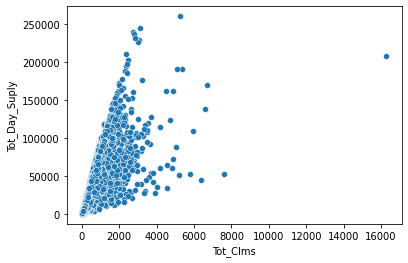

In [16]:
sns.scatterplot(data=df2, x="Tot_Clms", y="Tot_Day_Suply")

<AxesSubplot:xlabel='log_Tot_Clms', ylabel='log_Tot_Day_Suply'>

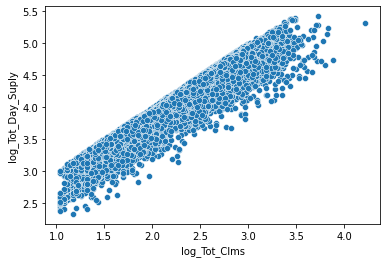

In [17]:
sns.scatterplot(data=df2, x="log_Tot_Clms", y="log_Tot_Day_Suply")

<AxesSubplot:xlabel='Tot_Drug_Cst', ylabel='Tot_Day_Suply'>

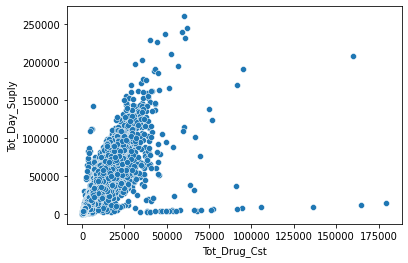

In [18]:
sns.scatterplot(data=df2, x="Tot_Drug_Cst", y="Tot_Day_Suply")

<AxesSubplot:xlabel='log_Tot_Drug_Cst', ylabel='log_Tot_Day_Suply'>

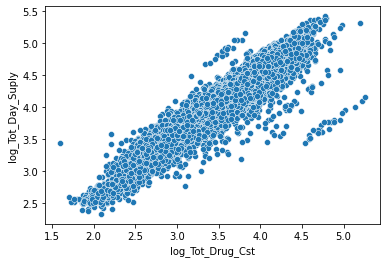

In [19]:
sns.scatterplot(data=df2, x="log_Tot_Drug_Cst", y="log_Tot_Day_Suply")

<AxesSubplot:xlabel='log_Tot_Benes', ylabel='log_Tot_Day_Suply'>

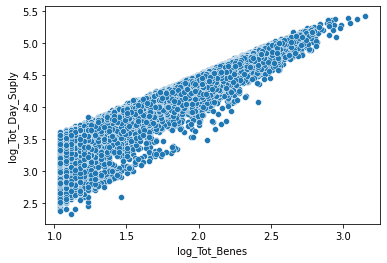

In [20]:
sns.scatterplot(data=df2, x="log_Tot_Benes", y="log_Tot_Day_Suply")

<AxesSubplot:xlabel='log_GE65_Tot_Benes', ylabel='log_Tot_Day_Suply'>

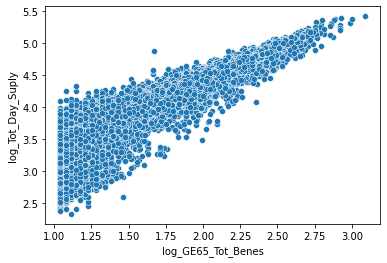

In [21]:
sns.scatterplot(data=df2, x="log_GE65_Tot_Benes", y="log_Tot_Day_Suply")

# Check for multi-collinearity

In [22]:
df3=df2[["Tot_Clms","Tot_Drug_Cst","Tot_Benes","GE65_Tot_Benes","log_Tot_Day_Suply","Tot_Day_Suply","Prscrbr_Type_Geriatric Medicine","Prscrbr_Type_Primary Care Physician"]]
df3['pat_gtr_65_ratio']=(df3["GE65_Tot_Benes"]/df3["Tot_Benes"]).round(2)
df3['drug_cst_per_65_plus']=(df3["Tot_Drug_Cst"]/df3["GE65_Tot_Benes"]).round(2)
df3['log_pat_gtr_65_ratio']=np.log10(df3['pat_gtr_65_ratio'])
df3['log_drug_cst_per_65_plus']=np.log10(df3['drug_cst_per_65_plus'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

<AxesSubplot:>

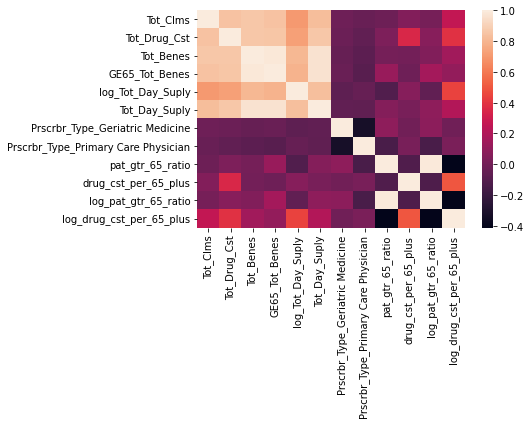

In [23]:
sns.heatmap(df3.corr())

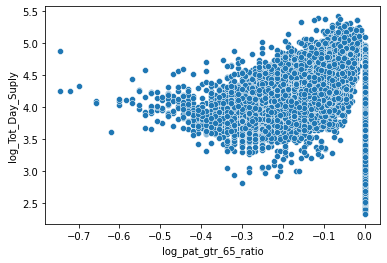

In [24]:
p1 = sns.scatterplot(data=df3, x='log_pat_gtr_65_ratio', y="log_Tot_Day_Suply")

<AxesSubplot:xlabel='log_drug_cst_per_65_plus', ylabel='log_Tot_Day_Suply'>

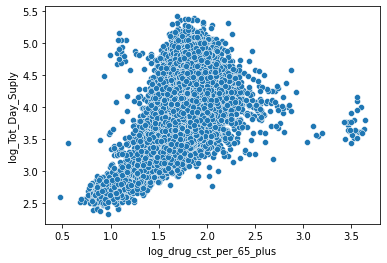

In [25]:
sns.scatterplot(data=df3, x="log_drug_cst_per_65_plus", y="log_Tot_Day_Suply")

# Linear Regression

In [48]:
X1 = ['log_pat_gtr_65_ratio']
X2 = ['log_pat_gtr_65_ratio', 'log_drug_cst_per_65_plus']
X3 = ['log_pat_gtr_65_ratio', 'log_drug_cst_per_65_plus','Prscrbr_Type_Geriatric Medicine','Prscrbr_Type_Primary Care Physician']

reg1 = sm.OLS(df3['log_Tot_Day_Suply'], df3[X1]).fit()
reg2 = sm.OLS(df3['log_Tot_Day_Suply'], df3[X2]).fit()
reg3 = sm.OLS(df3['log_Tot_Day_Suply'], df3[X3]).fit()

In [49]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3'
                                        ],
                            info_dict=info_dict,
                            regressor_order=['log_pat_gtr_65_ratio',
                                             'log_drug_cst_per_65_plus',
                                            'Prscrbr_Type_Geriatric Medicine',
                                            'Prscrbr_Type_Primary Care Physician'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                  Table 2 - OLS Regressions
                                     Model 1  Model 2 Model 3 
--------------------------------------------------------------
Prscrbr_Type_Geriatric Medicine                       -0.23***
                                                      (0.02)  
Prscrbr_Type_Primary Care Physician                   0.09*** 
                                                      (0.01)  
R-squared                           0.52      0.99    0.99    
R-squared Adj.                      0.52      0.99    0.99    
log_drug_cst_per_65_plus                      2.39*** 2.35*** 
                                              (0.00)  (0.00)  
log_pat_gtr_65_ratio                -28.53*** 1.68*** 1.74*** 
                                    (0.12)    (0.03)  (0.03)  
R-squared                           0.52      0.99    0.99    
No. observations                    51991     51991   51991   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [50]:
print(reg3.summary())

                                 OLS Regression Results                                
Dep. Variable:      log_Tot_Day_Suply   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.360e+06
Date:                Sat, 16 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:14:17   Log-Likelihood:                         -27768.
No. Observations:               51991   AIC:                                  5.554e+04
Df Residuals:                   51987   BIC:                                  5.558e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

For every 1% increase in ratio of 65+, the days supply increases by 1.74%.
If a HCP is a PCP, then log day's supply increases by 0.09%, day's suppy increases by 9%.
The base model assumes the HCP is a Cardiologist, making that the benchmark (Cardiologists excluded to prevent multicoliniarity). A PCP is provides 9% more day's supply of Atorvastatin than a Cardiologist, while a Geriatric Specialist is likely to provide 23% less day's supply.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


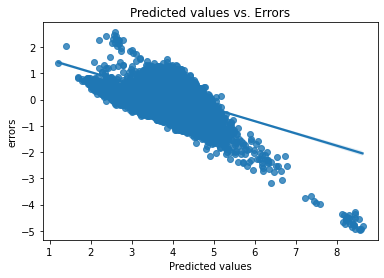

In [52]:
def print_resids(preds, resids):
    ax = sns.regplot(preds, resids);
    ax.set(xlabel = 'Predicted values', ylabel = 'errors', title = 'Predicted values vs. Errors')
    plt.show();
    
print_resids(reg3.predict(df3[X3]), reg3.resid)

Plotting the predicted values against the errors, reveals a relationship between the predicted values and the errors violating both the the assumptions of endogeneity and homoscedasticity. 

### Endogeneity:
Despite the above model having strong predictive power (r2=0.9), it may result in biased results that misattribute the day's supply amount. 

One possibility is that there is a feedback loop. For example, it may be possible that HCP's who provide a patient with 1 Rx of Atorvastatin subsequently gain more patients over 65 as word of mouth spreads. Another possibility is that the increase in Rx of Atorvastatin increase, result in a rise in cost per patient. 

In addition to feedback loops, another confound may be that some variables are not considered in the analysis, such as regulations governing the distribution of prescription medications by state, the affiliation of a HCP to a health care organization, or the introduction of generic medication in the market space.

### Homoscedasticity:
The model works well at predicting values between 3 and 6, but underperforms at predicting higher percent change in values of day's supply.  

# Next Steps

- Read and inplement a Two-Stage Least Squares (2SLS) Regression Analysis to address the Endogeneity / remove outliers to address homoscedasticity.

- Instead of predicting the day's supply, cluster the HCP's to better understand the behavior of HCP's

- Use a one sided t-test to determine determine whether PCP's tend to provide more day's supply of Atorvastatin than Cardiologist